In [2]:
pip install alibi-detect

     |████████████████████████████████| 207 kB 7.0 MB/s 
     |████████████████████████████████| 2.9 MB 49.2 MB/s 
     |████████████████████████████████| 4.8 MB 46.3 MB/s 
     |████████████████████████████████| 454.4 MB 9.1 kB/s 
     |████████████████████████████████| 4.0 MB 28.7 MB/s 
     |████████████████████████████████| 462 kB 60.6 MB/s 
     |████████████████████████████████| 1.2 MB 60.8 MB/s 
     |████████████████████████████████| 3.3 MB 58.2 MB/s 
     |████████████████████████████████| 895 kB 61.8 MB/s 
     |████████████████████████████████| 636 kB 76.4 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.41.0
    Uninstalling grpcio-1.41.0:
      Successfully uninstalled grpcio-1.41.0
  Attempting uninstall: tensorflow-estimator
    Found exist

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import shutil
from collections import Counter
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D,\
    Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D
from alibi_detect.od import OutlierAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

def img_to_np(path, resize = True):  
    img_array = []
    fpaths = glob.glob(path, recursive=True)
    for fname in fpaths:
        img = Image.open(fname).convert("RGB")
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
    images = np.array(img_array)
    return images
  
path_train = "/content/drive/My Drive/bottle/train/**/*.*"
path_test = "/content/drive/My Drive/bottle/test/**/*.*"

train = img_to_np(path_train)
test = img_to_np(path_test)
train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

In [7]:
encoding_dim = 1024
dense_dim = [8, 8, 128]

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

od = OutlierAE( threshold = 0.001,
                encoder_net=encoder_net,
                decoder_net=decoder_net)

adam = tf.keras.optimizers.Adam(lr=1e-4)

od.fit(train, epochs=100, verbose=True,
       optimizer = adam)

od.infer_threshold(test, threshold_perc=95)

preds = od.predict(test, outlier_type='instance',
            return_instance_score=True,
            return_feature_score=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



4/4 [=] - 9s 2s/step - loss_ma: 0.0013


In [8]:
for i, fpath in enumerate(glob.glob(path_test)):
    if(preds['data']['is_outlier'][i] == 1):
        source = fpath
        shutil.copy(source, 'img\\')
        
filenames = [os.path.basename(x) for x in glob.glob(path_test, recursive=True)]

dict1 = {'Filename': filenames,
     'instance_score': preds['data']['instance_score'],
     'is_outlier': preds['data']['is_outlier']}
     
df = pd.DataFrame(dict1)
df_outliers = df[df['is_outlier'] == 1]

print(df_outliers)

   Filename  instance_score  is_outlier
13  013.png        0.005985           1
20  006.png        0.011217           1
23  012.png        0.007148           1
40  017.png        0.005819           1
52  012.png        0.005670           1


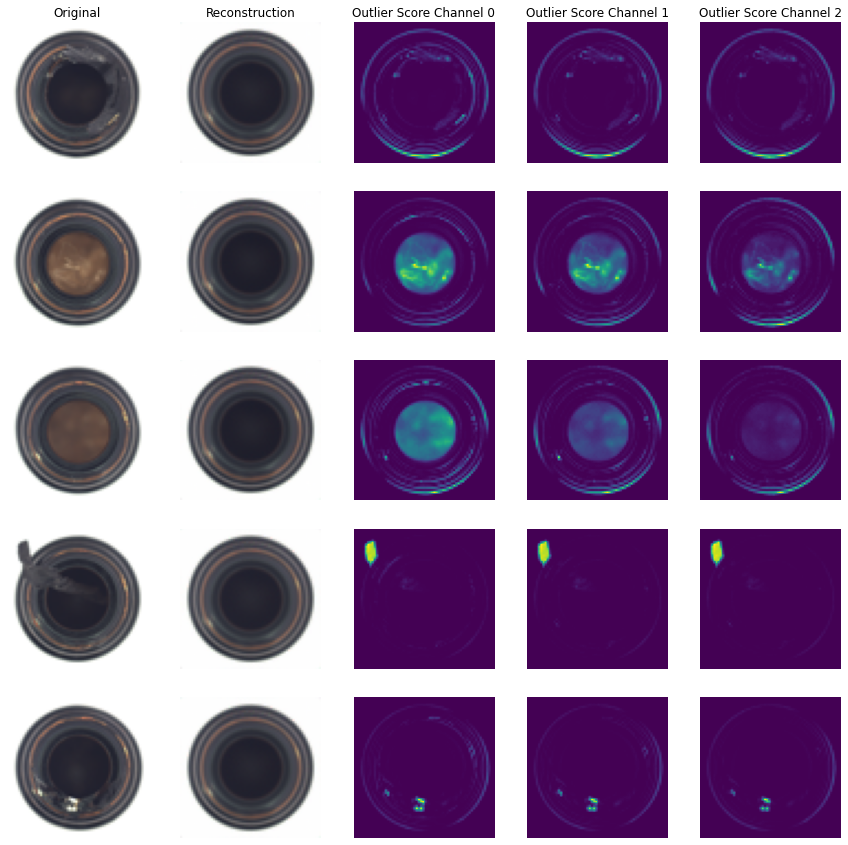

In [9]:
recon = od.ae(test).numpy()

plot_feature_outlier_image(preds, test, 
                           X_recon=recon,  
                           max_instances=5,
                           outliers_only=True,
                           figsize=(15,15))